In [ ]:
import pandas as pd
# import numpy as np

# text preprocessing
from nltk import word_tokenize
from nltk.stem import PorterStemmer
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

# feature extraction / vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# save and load a file
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Label_Questions_Train.csv')
model_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Label_Questions_Test.csv')

X_train = model_train.Question
X_test = model_test.Question

y_train = model_train.Label
y_test = model_test.Label

class_names = ['Multiplication', 'Division', 'Addition', 'Subtraction']
data = pd.concat([model_train, model_test])

In [ ]:
model_train

,Question,Label
0,කණුවක බැලූන් බෝල 2 ක බැගින් බැලූන් බෝල 600 ක් ...,Division
1,බිස්කට් 300 ක් ඇත. ළමයෙකුට බිස්කට් 2 බැගින් ළම...,Division
2,මීටර 90 ක් දිග කම්බියක් ඇත. සමාන කැබලි 2 බැගින...,Division
3,මීටර 60 ක් දිග ඉටි රෙද්දක් ඇත. මේසවලට දැමීම සද...,Division
4,පැන්සල් 420 ක් ඇත. ළමයෙකුට පැන්සල් 2 බැගින් ළම...,Division
...,...,...
324,කේට් ඇපල් 154 ක් මිලදී ගත් අතර එයින් 83 ක් කුණ...,Subtraction
325,ටේලර් විසින් අතින් සාදන ලද භාණ්ඩ 66 ක් දේශීය ප...,Subtraction
326,පැසිපන්දු තරගයකදී ගෝඨා පිල ලකුණු 50 ක්ද රනිල් ...,Subtraction
327,රොන් පරීක්ෂණයෙන් ලකුණු 76 ක් ලබා ගන්නා අතර ඔහු...,Subtraction


In [ ]:
def preprocess_and_tokenize(data):    

    #Remove html markup
    data = re.sub("(<.*?>)", "", data)

    #Remove urls
    data = re.sub(r'http\S+', '', data)
    
    #Remove hashtags and @names
    data= re.sub(r"(#[\d\w\.]+)", '', data)
    data= re.sub(r"(@[\d\w\.]+)", '', data)

    #Remove punctuation and non-ascii digits
    data = re.sub("(\\W|\\d)", " ", data)
    
    #Remove whitespace
    data = data.strip()
    
    #Tokenization with nltk
    data = word_tokenize(data)
    
    #Stemming with nltk
    porter = PorterStemmer()
    stem_data = [porter.stem(word) for word in data]
        
    return stem_data

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# TFIDF, unigrams and bigrams
vect = TfidfVectorizer(tokenizer=preprocess_and_tokenize, sublinear_tf=True, norm='l2', ngram_range=(1, 2))

# fit on our complete corpus
vect.fit_transform(data.Question)

# transform testing and training datasets to vectors
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

In [ ]:
#Classification using LogisticRegression 
# lbfgs solver was used to train the model
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
log.fit(X_train_vect, y_train)

ylog_pred = log.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ylog_pred) * 100))
print("F1 Score: {:.2f}%".format(f1_score(y_test, ylog_pred, average='micro') * 100))

print("Recall Score: {:.2f}%".format(recall_score(y_test, ylog_pred, average='micro') * 100))
print("Precision Score: {:.2f}%".format(precision_score(y_test, ylog_pred, average='micro') * 100))

print("Confusion Matrix : \n", confusion_matrix(y_test, ylog_pred))

Accuracy: 97.98%
F1 Score: 97.98%
Recall Score: 97.98%
Precision Score: 97.98%
Confusion Matrix : 
 [[29  0  0  0]
 [ 1 17  1  0]
 [ 0  0 20  0]
 [ 0  0  0 31]]


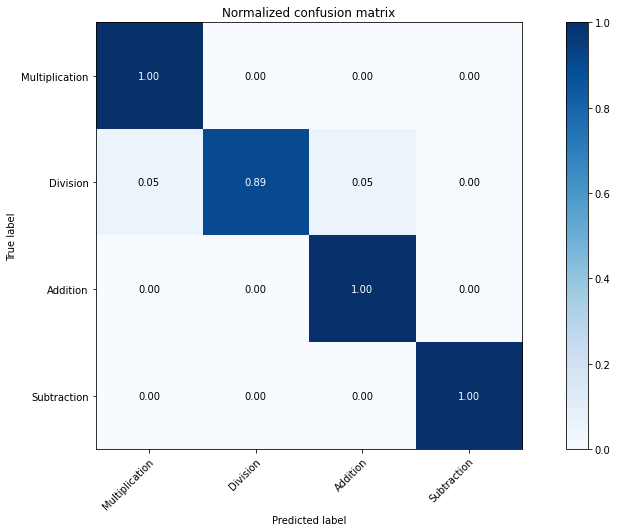

In [ ]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
   
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax




plot_confusion_matrix(y_test, ylog_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
#Create pipeline with our tf-idf vectorizer and  Logistic Regression model
#To stop the leaking of the accuracy 
log_model = Pipeline([
    ('lbfgs', vect),  #parameter value for the vectoriser 
    ('clf', log),     #parameter for the classification 
])

In [ ]:
# save the model
filename = '/content/drive/MyDrive/Colab Notebooks/Model2.sav'
pickle.dump(log_model, open(filename, 'wb'))

In [ ]:
model = pickle.load(open(filename, 'rb'))

question = 'පළතුරු වෙළෙන්දෙකුට ඇපල් 98 ක් තිබුණා. ඔහු එයින් ඇපල් 55 ක් විකුණුවා. ඔහු සමඟ ඇපල් කීයක් තිබුණාද?' 
model.predict([question])

array(['Subtraction'], dtype=object)